In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sample_t = np.linspace(-0.1, np.pi, 300)

short_amps = np.sin(sample_t)
long_amps = np.sin(sample_t-0.5)

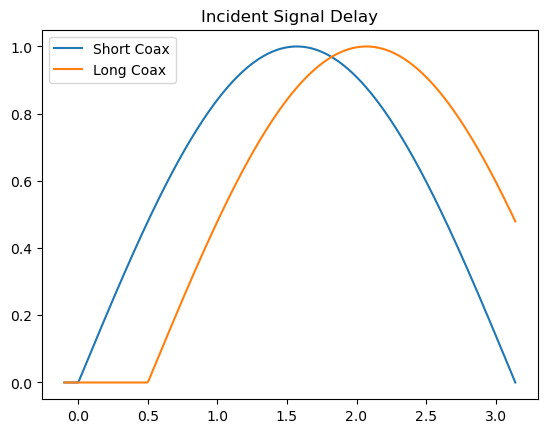

In [4]:
plt.plot(sample_t, [max(short_amps[i], 0) for i in range(len(short_amps))], label="Short Coax")
plt.plot(sample_t, [max(long_amps[i], 0) for i in range(len(long_amps))], label="Long Coax")
plt.title("Incident Signal Delay")
plt.legend()
plt.show()

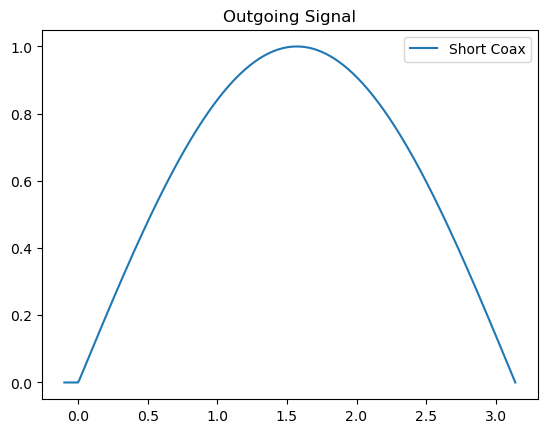

In [5]:
plt.plot(sample_t, [max(short_amps[i], 0) for i in range(len(short_amps))], label="Short Coax")
plt.title("Outgoing Signal")
plt.legend()
plt.show()

# Outline for Code

In [6]:
import pandas as pd
import scipy as sp
import csv

In [7]:
metadata = dict()
row_start = 14
filename_200k_1 = "sine/T0022ALL.CSV"
with open(filename_200k_1, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for (i, row) in enumerate(reader):
        if i > row_start: break
        if len(row) >= 2: metadata[row[0]] = row[1]
metadata

{'Model': 'MSO2024B',
 'Firmware Version': '1.56',
 'Point Format': 'Y',
 'Horizontal Units': 'S',
 'Horizontal Scale': '1e-05',
 'Sample Interval': '1e-09',
 'Filter Frequency': '2e+08',
 'Record Length': '100000',
 'Gating': '0.0% to 100.0%',
 'Probe Attenuation': '1',
 'Vertical Units': 'V',
 'Vertical Offset': '0',
 'Vertical Scale': '0.2',
 'Label': ''}

In [8]:
data_200k_1 = pd.read_csv(filename_200k_1, delimiter=",", header=row_start)

In [9]:
t_200k_1 = data_200k_1["TIME"].to_numpy()  # first trial for 200kHz
ch1_200k_1 = data_200k_1["CH1"].to_numpy()
ch2_200k_1 = data_200k_1["CH2"].to_numpy()
print(t_200k_1)

[-4.9560e-05 -4.9559e-05 -4.9558e-05 ...  5.0437e-05  5.0438e-05
  5.0439e-05]


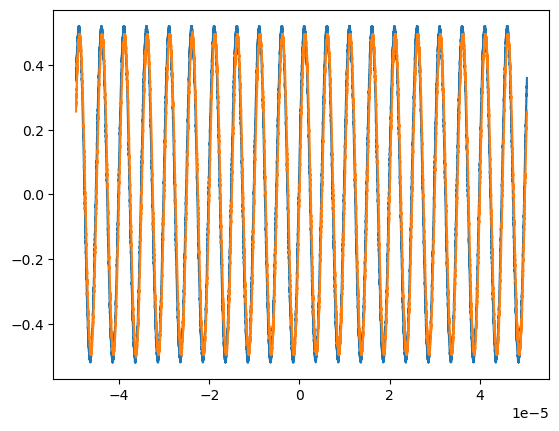

In [27]:
plt.plot(t_200k_1, ch1_200k_1)
plt.plot(t_200k_1, ch2_200k_1)
plt.show()

In [11]:
def sin_wave(t, omega, phi, a, c):
    return a * (np.sin(t * omega + phi)) + c

In [65]:
ff = np.fft.fftfreq(len(t_200k_1), (t_200k_1[1]-t_200k_1[0]))
Fyy = abs(np.fft.fft(ch1_200k_1))
guess_freq = abs(ff[np.argmax(Fyy[1:])+1])  # use a fast fourier transform to make frequency bins and then get the fft of the dataset to make a good guess of the frequency
# specifically it is finding the fast fourier transform, and then using the index of the first maximum of said fft, the index of that value in the frequency bins gives the right value - im not 100% certain i understand how the fft has the same bin size as the fftfreq

## TODO: CONVERT THIS WHOLE SECTION INTO A SINGLE FUNCTION TO GET THE PHASE SHIFT AND SPEED OF LIGHT FOR ANY GIVEN PAIR OF SINE WAVE FUNCTIONS

In [13]:
guess = [2 * np.pi * guess_freq, 0, np.std(ch1_200k_1) * 2.**0.5, np.mean(ch1_200k_1)]

In [14]:
poptch1200k1, pcovch1200k1 = sp.optimize.curve_fit(sin_wave, t_200k_1, ch1_200k_1, p0=guess)
poptch2200k1, pcovch2200k1 = sp.optimize.curve_fit(sin_wave, t_200k_1, ch2_200k_1, p0=guess)

To convert from phi (offset) which is in radians, to the time difference, need to have the phase difference between the two waves (next box), and in its base state if the short channel has a larger value of phi, that is good and you can simply use as is, but if the long channel has the larger value of phi, i think you need to add 2pi to the value. Then, divide that phi difference by the omega frequency, and divide the distance between the two values 

In [70]:
phi_200k_1 = (poptch1200k1 - poptch2200k1)[1]  # phase offset between the two channels

In [71]:
time_delay = phi_200k_1 / poptch1200k1[0]

In [72]:
(28.912 - 2.04) / time_delay

157042466.46361515

In [74]:
poptch1200k1, poptch2200k1

(array([ 1.25663342e+06,  2.14829720e-01,  5.12719516e-01, -4.74247883e-04]),
 array([ 1.25663834e+06, -1.96533352e-04,  4.91324550e-01, -1.82578257e-03]))

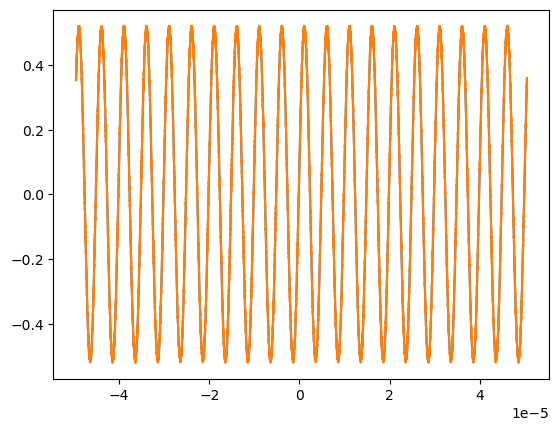

In [241]:
plt.plot(t_200k_1, sin_wave(t_200k_1, *poptch1200k1))
plt.plot(t_200k_1, ch1_200k_1)

In [75]:
length_diff = 28.912 - 2.04
length_err = np.sqrt(0.02 ** 2 + 0.144 ** 2)
length_rel_err = length_err / length_diff

In [76]:
def signal_prop_speed(time, short_channel, long_channel):
    freq_bins = np.fft.fftfreq(len(time), (time[1]-time[0]))
    fourier = abs(np.fft.fft(short_channel))
    freq_guess = abs(freq_bins[np.argmax(fourier[1:])+1])  # dont need to make a guess for each, sp takes it from here
    p0 = [2 * np.pi * freq_guess, 0, np.std(short_channel) * 2.**0.5, np.mean(short_channel)]
    short_popt, short_pcov = sp.optimize.curve_fit(sin_wave, time, short_channel, p0=p0)
    long_popt, long_pcov = sp.optimize.curve_fit(sin_wave, time, long_channel, p0=p0)
    phi_diff = abs(long_popt - short_popt)[1]
    time_diff = phi_diff / short_popt[0]
    signal_prop_speed = length_diff / time_diff
    freq_rel_err = short_pcov[0] / short_popt[0]
    phi_rel_err = np.sqrt((short_pcov[1] ** 2 + long_pcov[1] ** 2)) / phi_diff
    signal_prop_err = signal_prop_speed * np.sqrt((length_rel_err) ** 2 + (freq_rel_err) ** 2 + (phi_rel_err) ** 2)
    return [signal_prop_speed, signal_prop_err]

In [77]:
signal_prop_speed(t_200k_1, ch1_200k_1, ch2_200k_1)

[157042466.46361515,
 array([849628.0404526 , 849627.41396452, 849627.41396388, 849627.41396388])]